# Importações

## Bibliotecas

Instalaçao da Biblioteca pmdarima para encontrar os parâmetros do modelo (se for a primeira vez que roda o código, a instalação é feita apenas descomentando a célula)

In [ ]:
# !pip install pmdarima

In [ ]:
## Importações para tratamento e visualização dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importações para visualização da sazonalidade
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

## Importações para modelagem
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Importações para métricas
from sklearn.metrics import mean_squared_error
from math import sqrt

## Dataset

In [ ]:
df = pd.read_excel('/content/Dados.xlsx')
df.head()

,Data,Vendas
0,2022-12-06,870
1,2022-12-07,868
2,2022-12-08,1189
3,2022-12-09,742
4,2022-12-10,317


# Entendimento do Negócio

Previsão de demanda é uma projeção realizada com o intuito de prever o potencial de vendas de um ou mais produtos em um cenário futuro.

Com base em dados e informações, numéricas e intencionais, o objetivo da previsão é aproximar ao máximo a perspectiva da realidade. Embora não seja possível determinar as ações do futuro, a estimativa permite guiar a tomada de decisão e elaborar um planejamento mais estratégico, voltado para as possibilidades reais do negócio.

Nos diversos setores, a previsão de demanda serve de amparo para nortear e orientar as ações mais importantes.

A Frexco trabalha com produtos perecíveis e muitos deles possuem uma data de validade curta. Acertar na previsão de demanda é essencial para evitar o desperdício de alimentos, além de também ser importante garantir que se tenha o produto disponível no estoque para venda.

Tendo isso em mente, será estruturado um script no Python que calcule a previsão de demanda para os próximos 5 dias do item, baseando-se no histórico presente na base de dados em anexo.


# Entendimento dos Dados

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    46 non-null     datetime64[ns]
 1   Vendas  46 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 864.0 bytes


In [ ]:
print(f'Há {df.duplicated().sum()} dados duplicadas')

Há 0 dados duplicadas


In [ ]:
print(f'Há {df.isna().sum().sum()} dados nulos')

Há 0 dados nulos


In [ ]:
df = df.sort_values(by = 'Data')
df = df.set_index('Data')

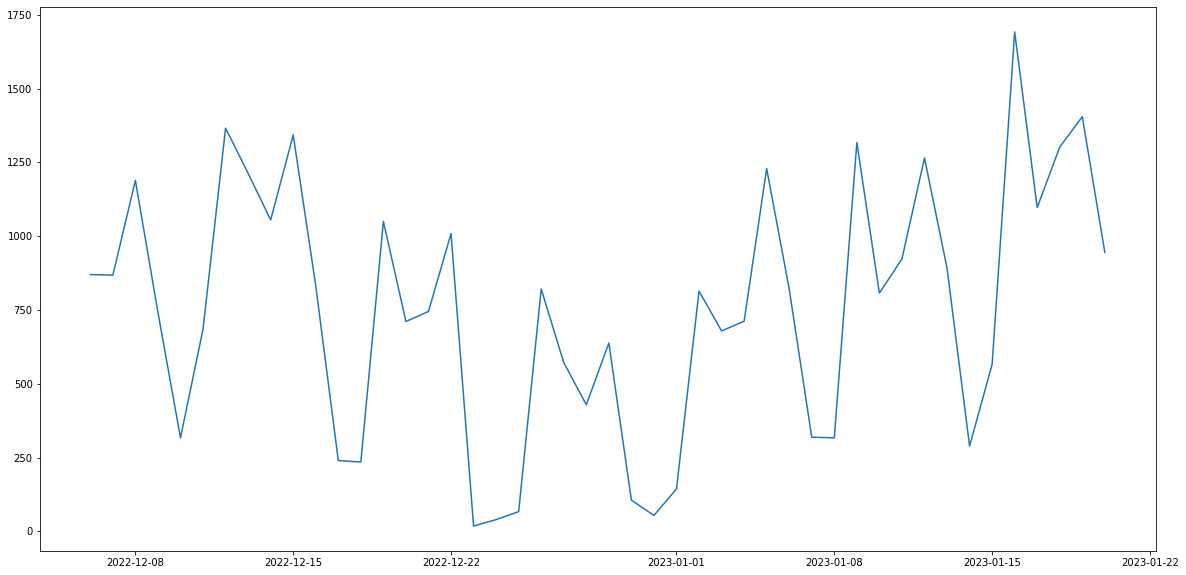

In [ ]:
fig = plt.figure(figsize = (20,10))
plt.plot(df.index, df['Vendas'])
plt.show()

Verificação da Sazonalidade (Gráfico Seasonal)

<Figure size 1440x720 with 0 Axes>

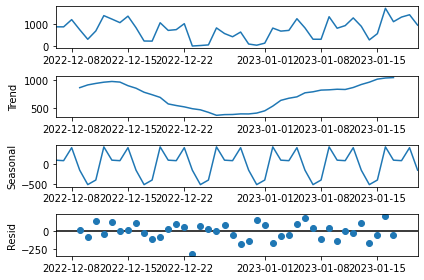

In [ ]:
fig = plt.figure(figsize = (20,10))
resultado = seasonal_decompose(df, model = 'add', period = 7)
fig = resultado.plot()

Verificando se a Série Temporal é estacionária (características estatísticas (média, variância, autocorrelação) são constantes ao longo do tempo)

In [ ]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('A Série É estacionária')
    else:
        print('A Série NÃO É estacionária')

In [ ]:
seasonal = resultado.seasonal
check_stationarity(df['Vendas'])

A Série NÃO É estacionária


# Preparação dos Dados

Para treinar o modelo, os dados foram divididos em treino (70% iniciais do dataset) e teste (30% finais do dataset), portando, levando em conta a data.

In [ ]:
train_size = int(len(df) * 0.7)
test_size = int(len(df)) - train_size

In [ ]:
df_train, df_test = df[:train_size].dropna(), df[train_size:].dropna()

# Modelagem

## Modelagem para treinamento

O auto_arima nos da como output os parâmetros para o modelo ARIMA, que pode ser utilizado no SARIMAX (modelo que será utilizado), adicionando a sazonalidade

In [ ]:
fit_arima = auto_arima(df_train,
                       D = 1,
                       d = 1,
                       m = 7,
                       information_criterion = 'aic',
                       trace = True,
                       stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=332.117, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=332.965, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=331.720, Time=0.09 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=329.415, Time=0.39 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.52 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=330.835, Time=0.53 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=330.762, Time=0.54 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=332.740, Time=1.54 sec
 ARIMA(0,1,0)(2,1,0)[7] intercept   : AIC=331.250, Time=0.44 sec

Best model:  ARIMA(0,1,0)(2,1,0)[7]          
Total fit time: 6.821 seconds


In [ ]:
model = SARIMAX(df_train, order = (0,1,0), seasonal_order= (2,1,0,7))
resultado_sarimax = model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Sumário do modelo SARIMAX

In [ ]:
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            Vendas   No. Observations:                   32
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 7)   Log Likelihood                -161.707
Date:                           Tue, 31 Jan 2023   AIC                            329.415
Time:                                   13:02:19   BIC                            332.949
Sample:                               12-06-2022   HQIC                           330.352
                                    - 01-06-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.5944      0.207     -2.871      0.004      -1.000      -0.189
ar.S.L14      -0.7004      0.210     -3.330      0.001      -1.113      -0.288
sigma2      2.709e+04   1.53e+04      1.768      0.077   -2939.922    5.71e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.40   Prob(JB):                         0.90
Heteroskedasticity (H):               1.51   Skew:                             0.21
Prob(H) (two-sided):                  0.57   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predições do Modelo para Dados de Treino

In [ ]:
predicoes = resultado_sarimax.get_prediction()
predicoes_media = predicoes.predicted_mean

In [ ]:
datas_previsao = np.asarray(predicoes_media.index)
datas = np.asarray(df.index)

Abaixo temos o gráfico que mostra a predição do modelo para os dados de treino, porém temos que rodar os dados para teste para analisar se há overfit no modelo, que é quando a previsão se comporta bem para os dados de treino, mas para os dados de teste (que o modelo nunca viu) performa mal.

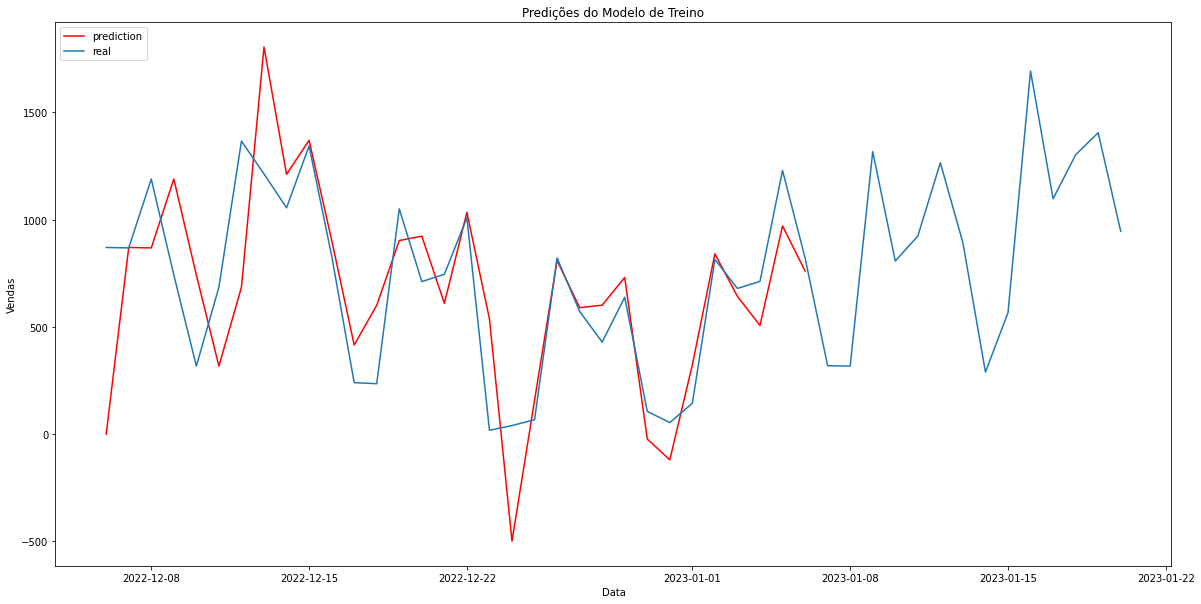

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(datas_previsao, predicoes_media.values, color = 'red', label = 'prediction')
plt.plot(datas, df.values, label = 'real')
plt.legend(loc="upper left")
plt.title('Predições do Modelo de Treino')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.show()

### Predições do Modelo para Dados de Teste

In [ ]:
predicao_test = resultado_sarimax.predict(start = df_test.index[0], end = df_test.index[-1])
predicao_test

2023-01-07     382.915282
2023-01-08     413.053997
2023-01-09    1175.710448
2023-01-10     909.909232
2023-01-11     962.272767
2023-01-12    1334.721800
2023-01-13     531.514132
2023-01-14     374.750725
2023-01-15     396.343249
2023-01-16    1162.761692
2023-01-17     894.858522
2023-01-18     812.434889
2023-01-19    1055.069411
2023-01-20     399.918566
Freq: D, Name: predicted_mean, dtype: float64

In [ ]:
datas_previsao_test = np.asarray(predicao_test.index)

A linha tracejada do gráfico abaixo mostra a previsão para os dados de teste, mostrando que o modelo não tem overfit, pois performa bem para dados que não estava no treinamento

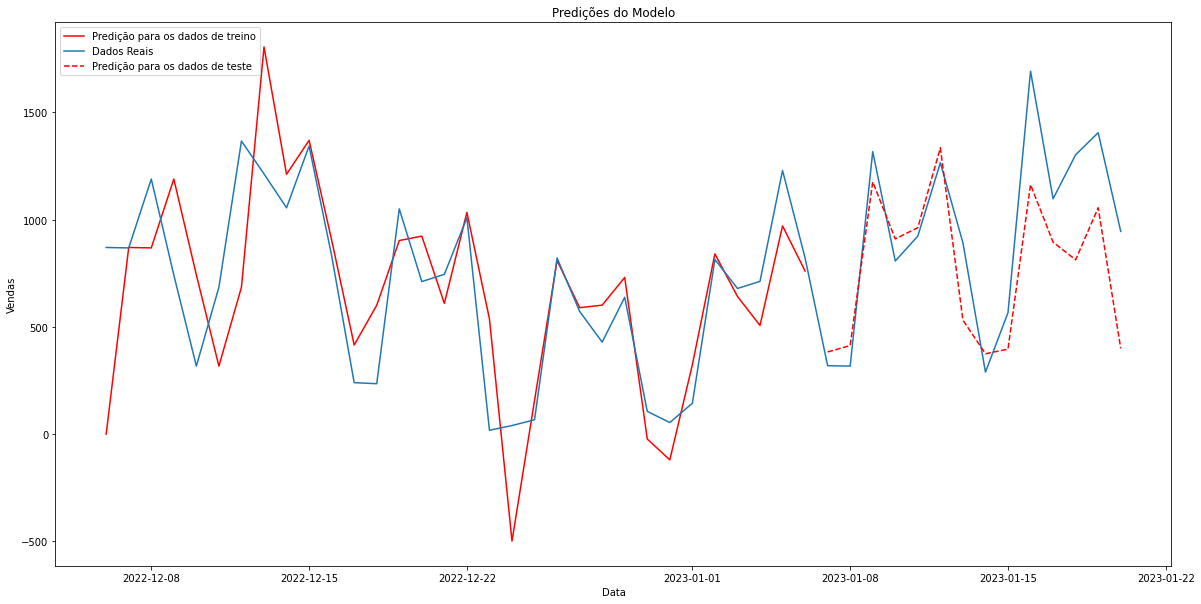

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(datas_previsao, predicoes_media.values, color = 'red', label = 'Predição para os dados de treino')
plt.plot(datas, df.values, label = 'Dados Reais')
plt.plot(datas_previsao_test, predicao_test.values, color = 'red', label = 'Predição para os dados de teste', linestyle = '--')
plt.legend(loc="upper left")
plt.title('Predições do Modelo')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.show()

### Métricas

Residuos são retirados da diferença entre o que foi predito e o dado real. Seria como se fosse o "erro" da previsão.

É interessante ver a distribuição dos resíduos para analisar se teve algum viés ou se ainda há sazonalidade no resíduo, mostrando que o modelo ainda pode ser melhorado

In [ ]:
residuals = pd.DataFrame(resultado_sarimax.resid)

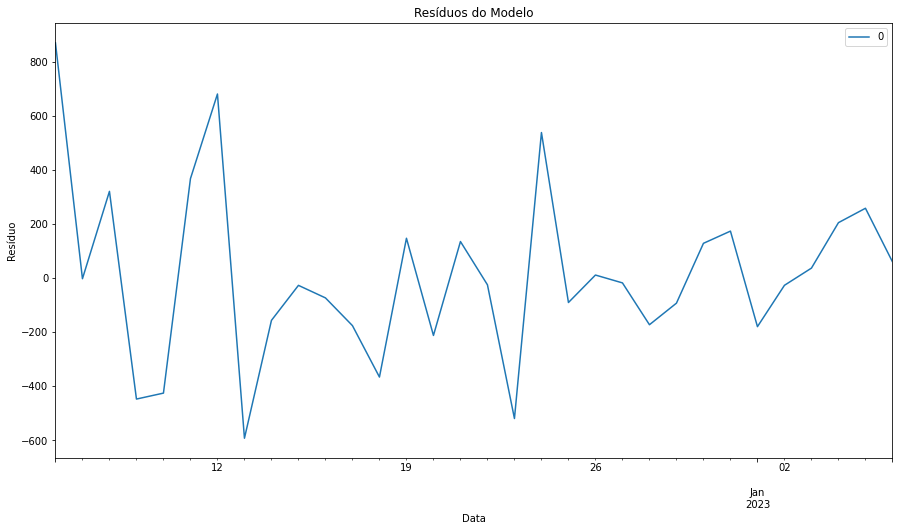

In [ ]:
residuals.plot(figsize = (15,8))
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.title('Resíduos do Modelo')
plt.show()

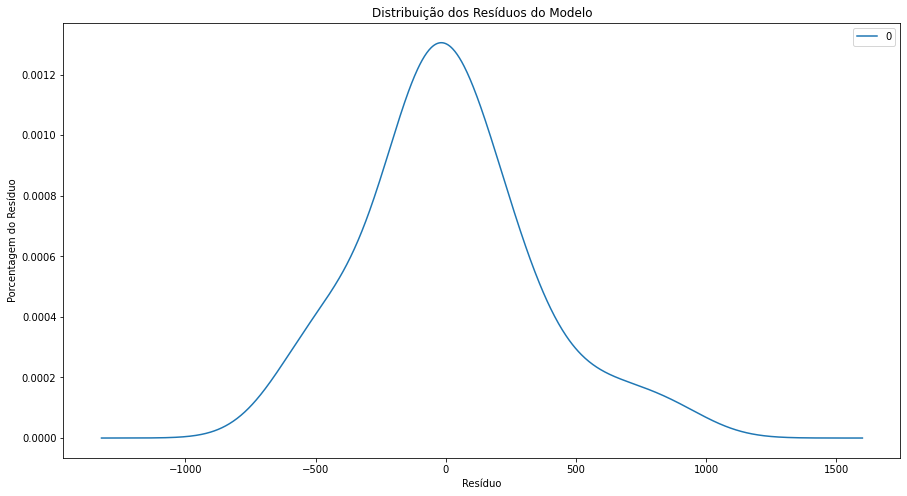

In [ ]:
residuals.plot(kind = 'kde', figsize = (15,8))
plt.xlabel('Resíduo')
plt.ylabel('Porcentagem do Resíduo')
plt.title('Distribuição dos Resíduos do Modelo')
plt.show()

Métrica de RMSE (Raiz Quadrada do Erro Médio) - Nos dá uma idéia de quanto o modelo está errando em média, na unidade do dado (nesse caso, número de vendas)

In [ ]:
rmse = sqrt(mean_squared_error(df[-test_size:], predicao_test[:].values))
rmse

292.3486507096467

## Modelagem para predição dos próximos 5 dias

Com o modelo validado, podemos rodar novamente (agora com o dataset todo) para prever o número de vendas para os próximos 5 dias

In [ ]:
model = SARIMAX(df, order = (0,1,0), seasonal_order= (2,1,0,7))
resultado_sarimax = model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
data_prox5dias = pd.DataFrame(pd.date_range(start = '2023-01-20', end = '2023-01-25'), columns = ['Proximos 5 dias']).set_index('Proximos 5 dias')
data_prox5dias

""
Proximos 5 dias
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25


In [ ]:
predicao_prox5dias = resultado_sarimax.predict(start = data_prox5dias.index[0], end = data_prox5dias.index[-1])
predicao_prox5dias

2023-01-20     958.537315
2023-01-21     600.670938
2023-01-22     839.247141
2023-01-23    1759.730234
2023-01-24    1380.543278
2023-01-25    1516.389699
Freq: D, Name: predicted_mean, dtype: float64

In [ ]:
datas_previsao_prox5dias = np.asarray(predicao_prox5dias.index)

No gráfico abaixo, a linha tracejada nos mostra a previsão da quantidade de vendas para os próximos 5 dias

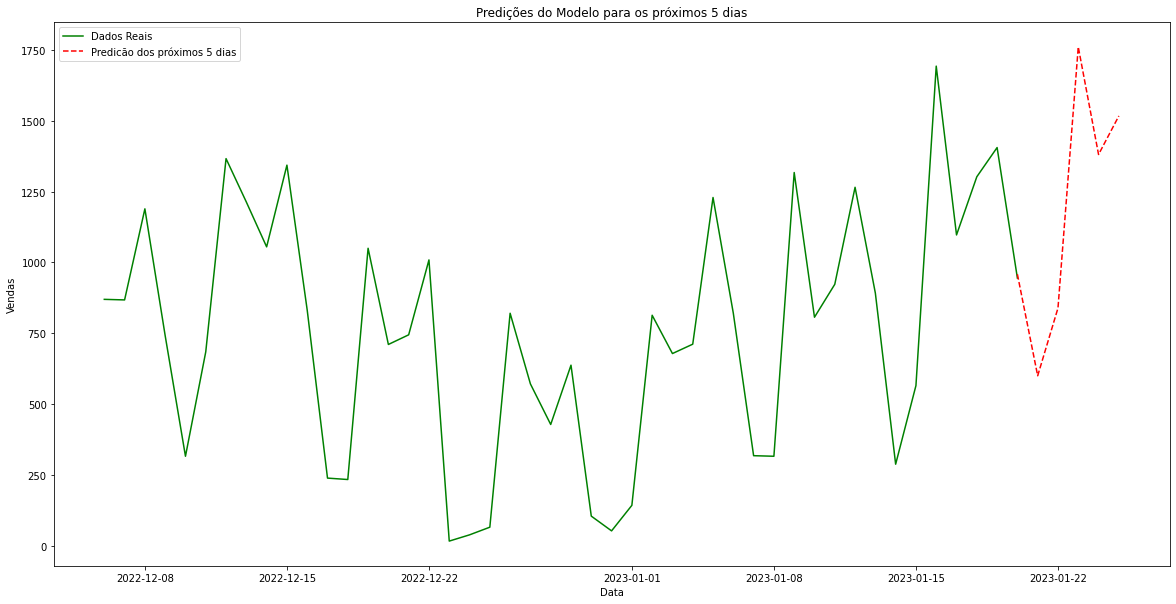

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(datas, df.values, label = 'Dados Reais', color = 'green')
plt.plot(datas_previsao_prox5dias, predicao_prox5dias.values, color = 'red', label = 'Predicão dos próximos 5 dias', linestyle = '--')
plt.legend(loc="upper left")
plt.title('Predições do Modelo para os próximos 5 dias')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.show()

In [ ]:
pd.DataFrame(predicao_prox5dias).reset_index().rename({'index': 'Data', 'predicted_mean': 'Quantidade de vendas'}, axis = 1).set_index('Data')

,Quantidade de vendas
Data,
2023-01-20,958.537315
2023-01-21,600.670938
2023-01-22,839.247141
2023-01-23,1759.730234
2023-01-24,1380.543278
2023-01-25,1516.389699
